In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [4]:
dataset = datasets.ImageFolder("./dataset", transform=train_transform)

# split 70/15/15
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(SEED))

val_ds.dataset.transform = val_transform
test_ds.dataset.transform = val_transform

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

class_names = dataset.classes
print("Classes:", dataset.classes)

Classes: ['Hawar', 'Karat', 'Sehat']


In [5]:
def build_model(model_name, num_classes):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Model not supported")
    return model.to(device)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # Validate
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / total

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} "
              f"- Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{type(model).__name__}.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training complete.")

In [7]:
def evaluate_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {type(model).__name__}")
    plt.show()


===== Training RESNET50 =====


d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Miniconda\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\Miniconda\envs\dl_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 - Train Loss: 0.3517 Acc: 0.8849 - Val Loss: 0.1664 Acc: 0.9524
Epoch 2/10 - Train Loss: 0.1755 Acc: 0.9410 - Val Loss: 0.1221 Acc: 0.9609
Epoch 3/10 - Train Loss: 0.1214 Acc: 0.9578 - Val Loss: 0.0980 Acc: 0.9711
Epoch 4/10 - Train Loss: 0.1095 Acc: 0.9610 - Val Loss: 0.0923 Acc: 0.9677
Epoch 5/10 - Train Loss: 0.1130 Acc: 0.9632 - Val Loss: 0.1060 Acc: 0.9643
Epoch 6/10 - Train Loss: 0.0908 Acc: 0.9701 - Val Loss: 0.0813 Acc: 0.9711
Epoch 7/10 - Train Loss: 0.0786 Acc: 0.9734 - Val Loss: 0.0767 Acc: 0.9796
Epoch 8/10 - Train Loss: 0.0731 Acc: 0.9734 - Val Loss: 0.0769 Acc: 0.9762
Epoch 9/10 - Train Loss: 0.0763 Acc: 0.9723 - Val Loss: 0.0744 Acc: 0.9728
Epoch 10/10 - Train Loss: 0.0809 Acc: 0.9690 - Val Loss: 0.0758 Acc: 0.9728
Training complete.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23792\559994869.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))



Classification Report:
              precision    recall  f1-score   support

       Hawar       0.97      0.96      0.96       179
       Karat       0.96      0.97      0.97       214
       Sehat       1.00      1.00      1.00       197

    accuracy                           0.98       590
   macro avg       0.98      0.98      0.98       590
weighted avg       0.98      0.98      0.98       590



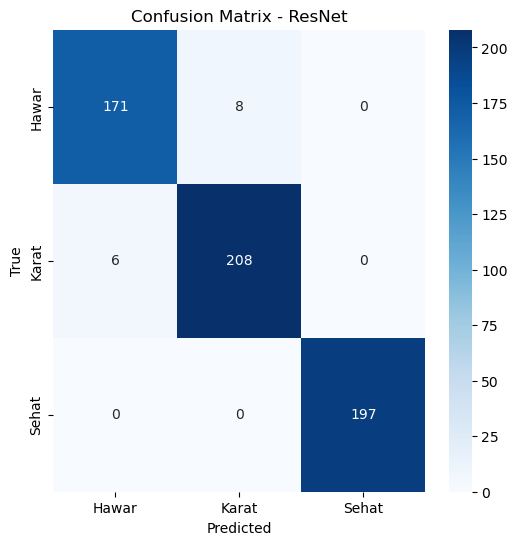

In [8]:
for arch in ["resnet50"]:
    print(f"\n===== Training {arch.upper()} =====")
    model = build_model(arch, num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=4)
    evaluate_model(model, f"best_{type(model).__name__}.pth")

In [9]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Hawar       0.97      0.95      0.96       194
       Karat       0.95      0.97      0.96       200
       Sehat       1.00      1.00      1.00       194

    accuracy                           0.97       588
   macro avg       0.97      0.97      0.97       588
weighted avg       0.97      0.97      0.97       588

